<a href="https://colab.research.google.com/github/HaoyueQ/text-analysis-final/blob/main/final_project_Haoyue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Shifting Public Discourse on Immigration: A Sentiment and TF–IDF Analysis of YouTube Reactions to the 2020 and 2024 U.S. Presidential Debates

## 1. Introduction

Immigration has long occupied a central place in American political conflict, functioning simultaneously as a policy issue, a symbolic battleground, and a touchpoint for broader debates about national identity, security, and economic opportunity. Presidential debates—broadcast widely across traditional and digital platforms—serve as key moments in which competing narratives around immigration are crystallized and disseminated. Increasingly, however, the public reception of these debates unfolds not through traditional media commentary but through online participatory spaces such as YouTube comment sections. These comment threads operate as “folk public spheres”  [(Graham & Wright, 2015)](https://journals.sagepub.com/doi/abs/10.1177/1940161215581926) where citizens express affect, evaluate candidates, circulate interpretations, and debate policy substance.

This study examines how public discourse on immigration differs across two electoral cycles by analyzing YouTube comments from immigration-focused segments of the 2020 and 2024 U.S. presidential debates. The central research question is:
*   **How did the emotional tone and thematic focus of public discourse on immigration shift between the 2020 and 2024 debate cycles?**

To answer this, the study applies sentiment analysis and TF-IDF topic extraction, enabling a comparison of both affective patterns and substantive discussion points. Beyond documenting differences, this project situates these findings within broader scholarship on affective polarization, mediated political discourse, and immigration framing.



## 2. Data and Methods

This study analyzes YouTube comments from two immigration-focused presidential debate clips, corresponding to the [2020](https://www.youtube.com/watch?v=DZ9vIzVZjS4) and [2024](https://www.youtube.com/watch?v=SAOjM6nj31o) election cycles. Comments were collected using an adapted version of [(Krisel 2025)](https://github.com/SIPA-Text-Analysis-F25/syllabus/blob/main/README.md) YouTube API script, extended to retrieve both top-level comments and all associated replies. After removing duplicates, non-text entries, and noise (URLs, non-alphanumeric characters), the final dataset contained 907 comments per year, balanced through random sampling to ensure comparability. Sentiment analysis was conducted using the VADER model, which produces continuous compound scores and categorizes comments as positive, negative, or neutral. Because sentiment tools often misclassify sarcasm and rhetorical exaggeration, a TF-IDF analysis was incorporated to capture distinctive topical patterns across years. The TF-IDF analysis was applied to normalized text using an expanded custom stopword list that removed candidate names, filler expressions, and platform-specific slang. Together, these methods allow for complementary insights into both the emotional tone and thematic content of public reactions to immigration debates.

###2.1 Data Source and YouTube API Collection

The following code is from[(Krisel 2025)](https://github.com/SIPA-Text-Analysis-F25/syllabus/blob/main/README.md)




In [37]:
import os
from getpass import getpass

# Paste your API key when prompted (input will be hidden in Colab)
os.environ["YOUTUBE_API_KEY"] = getpass("Paste your API Key: ")

# Quick sanity check
assert os.environ.get("YOUTUBE_API_KEY"), "API key not set — please run the cell and paste your key."



Paste your API Key: ··········


In [38]:
# Install required libraries, import dependencies, and define a helper function to query the YouTube API
!pip -q install --upgrade nltk requests tqdm

import os
import json
from urllib.parse import urlencode

import requests
import pandas as pd
from tqdm import tqdm

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

API_KEY = os.environ.get("YOUTUBE_API_KEY")
BASE_URL = "https://www.googleapis.com/youtube/v3"

def yt_get(resource: str, params: dict) -> dict:
    q = {**params, "key": API_KEY}
    url = f"{BASE_URL}/{resource}?{urlencode(q)}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    return r.json()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


To retrieve all comments for each debate clip, I adapted the top-level comment extraction function from [(Krisel 2025)](https://github.com/SIPA-Text-Analysis-F25/syllabus/blob/main/README.md) and, with additional guidance from ChatGPT, modified it to also include the inline replies exposed by the YouTube Data API. This captures both top-level comments and the visible subset of threaded replies that the API returns within each comment thread.

In [77]:
# Define a function to retrieve all top-level and reply comments from a YouTube video using the API
def fetch_comments_for_video(
    video_id: str,
    max_per_video: int = None,
    order: str = "relevance",
    include_replies: bool = True,
):

    all_comments = []
    page_token = None
    fetched = 0

    with tqdm(desc=f"Fetching comments for {video_id}", unit="page") as pbar:
        while True:
            params = {
                "part": "snippet,replies",
                "videoId": video_id,
                "maxResults": 100,
                "order": order,
                "textFormat": "plainText",
            }
            if page_token:
                params["pageToken"] = page_token

            data = yt_get("commentThreads", params)
            items = data.get("items", [])


            if not items:
                break

            for it in items:
                # -------- 1. top comment  --------
                top = it.get("snippet", {}).get("topLevelComment", {})
                s = top.get("snippet", {})

                all_comments.append({
                    "video_id": video_id,
                    "comment_id": top.get("id"),
                    "parent_id": None,
                    "author": s.get("authorDisplayName"),
                    "publishedAt": s.get("publishedAt"),
                    "likeCount": s.get("likeCount", 0),
                    "text": s.get("textOriginal", ""),
                })
                fetched += 1

                if max_per_video is not None and fetched >= max_per_video:
                    break

                # -------- 2. reply comments --------
                if include_replies:
                    replies = it.get("replies", {}).get("comments", [])
                    for r in replies:
                        rs = r.get("snippet", {})
                        all_comments.append({
                            "video_id": video_id,
                            "comment_id": r.get("id"),
                            "parent_id": top.get("id"),
                            "author": rs.get("authorDisplayName"),
                            "publishedAt": rs.get("publishedAt"),
                            "likeCount": rs.get("likeCount", 0),
                            "text": rs.get("textOriginal", ""),
                        })
                        fetched += 1

                        if max_per_video is not None and fetched >= max_per_video:
                            break


                if max_per_video is not None and fetched >= max_per_video:
                    break


            if max_per_video is not None and fetched >= max_per_video:
                break

            page_token = data.get("nextPageToken")
            if not page_token:
                break

            pbar.update(1)

    return all_comments

After implementing the full-thread retrieval function, I fetched all comments—including both top-level comments and replies—for the 2020 and 2024 debate videos. I then converted the raw comment objects into Pandas DataFrames, added a “debate_year” label to distinguish the two corpora, and concatenated them into a single dataset for subsequent cleaning and analysis.

In [78]:
VIDEO_ID_2020 = "DZ9vIzVZjS4"
VIDEO_ID_2024 = "SAOjM6nj31o"

comments_2020 = fetch_comments_for_video(VIDEO_ID_2020, max_per_video=None)
comments_2024 = fetch_comments_for_video(VIDEO_ID_2024, max_per_video=None)

df_2020 = pd.DataFrame(comments_2020)
df_2024 = pd.DataFrame(comments_2024)

df_2020["debate_year"] = 2020
df_2024["debate_year"] = 2024

comments_df = pd.concat([df_2020, df_2024], ignore_index=True)

print(comments_df.shape)
comments_df.head()


Fetching comments for DZ9vIzVZjS4: 5page [00:01,  2.50page/s]
Fetching comments for SAOjM6nj31o: 5page [00:02,  2.44page/s]

(1930, 8)


,video_id,comment_id,parent_id,author,publishedAt,likeCount,text,debate_year
0,DZ9vIzVZjS4,UgyKSlGgRjzwAW_ZlI14AaABAg,None,@isaiahfrisby5347,2023-11-14T22:36:51Z,54,Whos here 3 years later,2020
1,DZ9vIzVZjS4,UgyKSlGgRjzwAW_ZlI14AaABAg.9x6gTfjD_IgA9mPIS4npUo,UgyKSlGgRjzwAW_ZlI14AaABAg,@cleanup8984,2024-10-19T15:33:29Z,3,I voted for Trump in 2016 and 2020 And will be...,2020
2,DZ9vIzVZjS4,Ugw0_ve6IrOtkk-OUct4AaABAg,None,@lukadaylee7961,2021-04-01T20:11:17Z,105,This aged so well 😂😂,2020
3,DZ9vIzVZjS4,Ugw0_ve6IrOtkk-OUct4AaABAg.9LbE4Hp7gmv9uuA_qupIMY,Ugw0_ve6IrOtkk-OUct4AaABAg,@Deenaroshell,2023-09-20T23:36:33Z,10,And as of today…. Very freaking well 😂,2020
4,DZ9vIzVZjS4,Ugw0_ve6IrOtkk-OUct4AaABAg.9LbE4Hp7gmvA08aFG93-5V,Ugw0_ve6IrOtkk-OUct4AaABAg,@Cyd99,2024-02-23T02:26:30Z,2,Like wine.,2020


In [75]:
# Display the count of comments per debate year
print(comments_df["debate_year"].value_counts().sort_index())



debate_year
2020    938
2024    992
Name: count, dtype: int64


The dataset consists of YouTube comments retrieved from two debate clips focused on immigration, corresponding to the 2020 and 2024 U.S. presidential debates. The initial collection produced 938 comments from 2020 and 992 comments from 2024.

###2.2 Data Cleaning and Normalization

Text normalization was performed prior to analysis. All comments were subsequently cleaned through a standardized preprocessing pipeline that removed URLs, HTML entities, hashtags, repeated characters, and non-alphanumeric symbols, while converting text to lowercase. After removing rows with missing text and eliminating duplicate comments, the dataset was reduced to 907 comments from 2020 and 963 from 2024.


In [79]:
import re

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)          # URLs
    text = re.sub(r"[@#]\w+", " ", text)                   # @mentions, hashtags
    text = re.sub(r"&\w+;", " ", text)                     # HTML entities
    text = re.sub(r"[^a-z0-9\s\.,!?'-]", " ", text)        # keep basic chars
    text = re.sub(r"\s+", " ", text).strip()               # collapse spaces
    return text

# Drop empty text rows, then clean
df = comments_df.dropna(subset=["text"]).copy()
df = df.drop_duplicates(subset=["text"])

df["text_clean"] = df["text"].astype(str).apply(clean_text)


print(df[["debate_year", "text", "text_clean"]].head())
print("After cleaning and dropping duplicates:", df.shape)


   debate_year                                               text  \
0         2020                            Whos here 3 years later   
1         2020  I voted for Trump in 2016 and 2020 And will be...   
2         2020                               This aged so well 😂😂   
3         2020             And as of today…. Very freaking well 😂   
4         2020                                         Like wine.   

                                          text_clean  
0                            whos here 3 years later  
1  i voted for trump in 2016 and 2020 and will be...  
2                                  this aged so well  
3               and as of today . very freaking well  
4                                         like wine.  
After cleaning and dropping duplicates: (1870, 9)


In [80]:
print(df["debate_year"].value_counts())

debate_year
2024    963
2020    907
Name: count, dtype: int64


### 2.3 Stratified Sampling for Corpus Balance

To ensure comparability across years, I applied stratified random sampling to ensure that the 2020 and 2024 datasets contained an equal number of comments. After consulting ChatGPT for the implementation of randomized down-sampling in pandas, I sampled 907 comments from each year—the size of the smaller group. This process resulted in a harmonized dataset of 1,814 comments used in all subsequent analyses.

In [74]:
min_n = df["debate_year"].value_counts().min()

df = (
    df.groupby("debate_year", group_keys=False)
      .apply(lambda g: g.sample(n=min_n, random_state=42))
      .reset_index(drop=True)
)

print(df["debate_year"].value_counts())


debate_year
2020    907
2024    907
Name: count, dtype: int64


/tmp/ipython-input-2702591848.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min_n, random_state=42))


## 3. Analysis

### 3.1 Sentiment Analysis
#### 3.1.1 Method
For sentiment analysis, I applied the VADER (Valence Aware Dictionary for Sentiment Reasoning) model (Hutto & Gilbert, 2014), which is widely used for analyzing social media text due to its sensitivity to informal linguistic markers such as punctuation, capitalization, and emojis. I first implemented a function to compute VADER’s compound sentiment score for each cleaned comment, producing a continuous value ranging from –1 (extremely negative) to +1 (extremely positive). Following standard conventions in the literature, comments were then categorized as positive (compound > 0.05), negative (compound < –0.05), or neutral (between –0.05 and 0.05). The entire scoring and labeling workflow was adpated froin Krisel (2023), which helped structure and refine the code used for VADER-based classification.

In [82]:
# VADER setup
sia = SentimentIntensityAnalyzer()

def compound_score(text):

    return sia.polarity_scores(text or "")["compound"]

In [83]:
# Apply sentiment scoring
sent_df = df.copy()
sent_df["compound"] = sent_df["text_clean"].apply(compound_score)

# VADER thresholds
POS, NEG = 0.05, -0.05

def label_sentiment(c):
    if c > POS:
        return "pos"
    elif c < NEG:
        return "neg"
    else:
        return "neu"

sent_df["sentiment_label"] = sent_df["compound"].apply(label_sentiment)


sent_df[["debate_year", "text_clean", "compound", "sentiment_label"]].head()


,debate_year,text_clean,compound,sentiment_label
0,2020,whos here 3 years later,0.0000,neu
1,2020,i voted for trump in 2016 and 2020 and will be...,0.2732,pos
2,2020,this aged so well,0.4101,pos
3,2020,and as of today . very freaking well,-0.1815,neg
4,2020,like wine.,0.3612,pos


To visualize the distribution of sentiment across debate years, I constructed a grouped bar chart comparing the proportion of negative, neutral, and positive comments between 2020 and 2024.

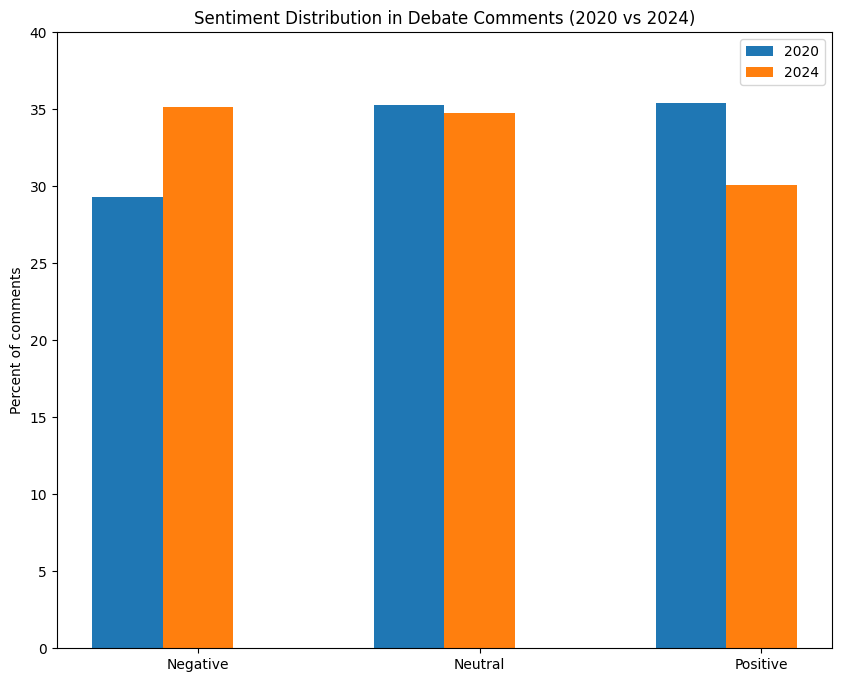

,debate_year,sentiment_label,pct
0,2020,neg,29.327453
1,2020,neu,35.281147
2,2020,pos,35.391400
3,2024,neg,35.170893
4,2024,neu,34.729879
5,2024,pos,30.099228


In [84]:
# Plot a side-by-side bar chart comparing the percentage distribution of negative, neutral, and positive comments between 2020 and 2024
order = ["neg", "neu", "pos"]
order_labels = ["Negative", "Neutral", "Positive"]
plt.figure(figsize=(10, 8))

for i, pres in enumerate(label_counts["debate_year"].unique()):
    sub = label_counts[label_counts["debate_year"] == pres]

    sub = sub.set_index("sentiment_label").loc[order].reset_index()

    plt.bar(
        [x + i*0.25 for x in range(len(sub))],
        sub["pct"],
        width=0.25,
        label=pres,
    )

plt.xticks([0.25, 1.25, 2.25], order_labels)
plt.ylabel("Percent of comments")
plt.title("Sentiment Distribution in Debate Comments (2020 vs 2024)")
plt.ylim(0, 40)
plt.legend()
plt.show()
label_counts[['debate_year', 'sentiment_label', 'pct']]

####3.1.2 Sentiment Analysis Results and Policy Implications

The results indicate a measurable shift in the emotional valence of online discourse across the two election cycles. In 2020, the distribution of sentiment was relatively symmetrical: positive (35.4%) and neutral (35.3%) comments each accounted for roughly one-third of the corpus, while negative sentiment constituted 29.3%. This pattern suggests a relatively heterogeneous mix of evaluative stances and a comparatively moderated tone.
By 2024, however, the sentiment landscape becomes more negative. The proportion of negative comments increased to 35.1%, marking a substantial rise of more than five percentage points, while positive sentiment declined to 30.1%. Neutral sentiment remained stable across years, indicating that the primary change is driven by a redistribution between positive and negative evaluations rather than a shift toward neutrality.
These findings point to a discernible intensification of negative affect in public reactions to immigration-related political communication. The rise in negativity and corresponding decline in positive engagement likely reflect broader trends in political polarization, heightened salience of border and security concerns, and an increasingly adversarial tone in public debate during the 2024 election cycle. Overall, the sentiment profile of 2024 suggests a more pessimistic and critical online environment compared to 2020.


### 3.2 TF-IDF Analysis

####3.2.1 Method

Sentiment classification alone is insufficient for capturing the pragmatics of online political language. As prior work shows, social-media sentiment models frequently misclassify sarcasm, rhetorical exaggeration, and oppositional humor. Because such tropes are abundant in YouTube debate commentaries, I complemented VADER scoring with a TF-IDF analysis. TF-IDF does not rely on emotional polarity and therefore provides an independent measure of the dominant topics and linguistic frames present in each debate year, reducing the risk that ironic expressions distort substantive interpretation. It will capture the substantive content of public reactions to immigration debates.

To improve the interpretability of the TF-IDF results, I expanded the stopword list beyond the default English set. YouTube debate comments contain many high-frequency but non-substantive tokens—such as conversational fillers (“like,” “really”), platform slang (“lol,” “lmao”), and emotional intensifiers (“good,” “bad,” “terrible”)—that do not meaningfully contribute to topic identification. I also removed candidate names (e.g., “Trump,” “Biden”) and generic political terms (“vote,” “debate,” “question”), which appear across both years and would otherwise dominate the vocabulary without indicating thematic differences. This expanded stopword set ensures that TF–IDF highlights genuinely distinctive lexical patterns—such as the policy-focused terms that characterize 2020 comments and the performance- and credibility-focused terms that characterize 2024.

In [86]:
# Build a TF-IDF model with an expanded custom stopword list to extract distinctive terms from the cleaned debate comments

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import numpy as np

extra_stopwords = {
    # candidate names
    "trump","trumps","donald","biden","bidens","joe","brandon",
    "president","presidents","term","obama",

    # meaningless fillers / discourse words
    "like","really","just","yes","come","know","think","look","looks",
    "want","way","going","go","got","getting","gotten","make","makes",
    "did","does","doing", "didn","doesn","dont", "say","says","said","called","saying",
    "talking","watch","watching","looking","needs","need","stand","don",
    "right","let","letting", "vs","speak","real","clearly","sure","fair","love","vs",
    "let","understand",


    # frequent nouns with no topic specificity
    "man","guy","guys","people","folks","anyone","someone","everyone",
    "country","american","america","usa","thing","things",

    # political junk words
    "vote","voted","voting","debate","term","questions","question",
    "answer","answers","cnn",

    # years / time references
    "time","year","years","day","tonight","2020","2021","2024",

    # emotional but non-thematic
    "good","great","better","best","bad","worse","terrible","awful",
    "wow","exactly","agree","true","literally","totally","hard","clear",


    # YouTube comment filler
    "lol","lmao","omg","wtf","haha","huh","btw","oh","god","yeah",
}


custom_stopwords = list(ENGLISH_STOP_WORDS.union(extra_stopwords))


sent_df = sent_df.reset_index(drop=True)
corpus = sent_df["text_clean"].astype(str).tolist()


tfidf_vec = TfidfVectorizer(
    stop_words=custom_stopwords,
    max_df=0.8,
    min_df=5,
    max_features=3000,
    ngram_range=(1, 2)
)

tfidf_matrix = tfidf_vec.fit_transform(corpus)
feature_names = np.array(tfidf_vec.get_feature_names_out())

print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("Sample vocab:", feature_names[:20])


TF-IDF matrix shape: (1870, 501)
Sample vocab: ['000' '10' '100' '11' '11 million' '15' '18' '19' '20' '24' '3rd' '50'
 '500' '500 kids' 'abandoned' 'able' 'abuse' 'actions' 'actually'
 'administration']


In [87]:
# Compute the top TF-IDF terms separately for 2020 and 2024 to identify the most distinctive vocabulary in each debate year
sent_df = sent_df.reset_index(drop=True)

df_2020 = sent_df[sent_df["debate_year"] == 2020]
df_2024 = sent_df[sent_df["debate_year"] == 2024]


top_2020 = top_tfidf_terms_for_group(df_2020, "2020", top_n=20)
top_2024 = top_tfidf_terms_for_group(df_2024, "2024", top_n=20)

top_2020.head(10), top_2024.head(10)


(  group         term     tfidf
 0  2020        cages  0.034629
 1  2020         kids  0.024930
 2  2020      parents  0.023484
 3  2020        built  0.021649
 4  2020       border  0.019053
 5  2020  built cages  0.018490
 6  2020     children  0.016542
 7  2020         aged  0.013775
 8  2020   immigrants  0.012348
 9  2020       family  0.011993,
   group    term     tfidf
 0  2024    lies  0.020223
 1  2024     old  0.014518
 2  2024     lie  0.013574
 3  2024  border  0.012315
 4  2024   lying  0.011442
 5  2024   world  0.009179
 6  2024    liar  0.009036
 7  2024     sad  0.008649
 8  2024     job  0.008621
 9  2024    lost  0.007575)

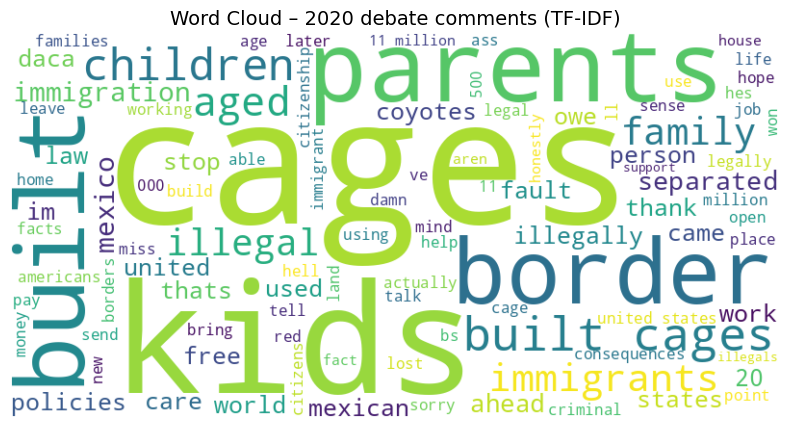

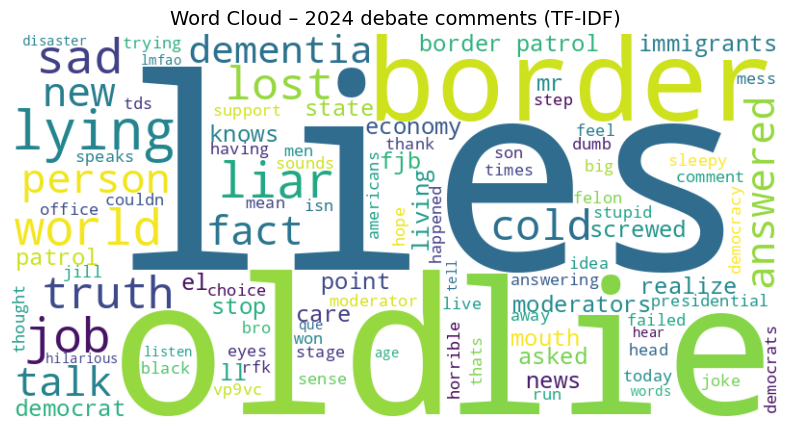

In [88]:
# Generate TF-IDF–based word clouds for 2020 and 2024 to visually compare the most distinctive terms in each debate year

!pip -q install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


df_2020 = sent_df[sent_df["debate_year"] == 2020]
df_2024 = sent_df[sent_df["debate_year"] == 2024]


wc_data_2020 = tfidf_dict_for_group(df_2020, top_n=100)
wc_data_2024 = tfidf_dict_for_group(df_2024, top_n=100)


def plot_wordcloud(freq_dict, title):
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

plot_wordcloud(wc_data_2020, "Word Cloud – 2020 debate comments (TF-IDF)")
plot_wordcloud(wc_data_2024, "Word Cloud – 2024 debate comments (TF-IDF)")



####3.2.2 TF-IDF Reults and Policy Implications
The TF-IDF results reveal substantial shifts in discussion topics between the 2020 and 2024 debate comment sections. In 2020, high-weight terms—including “cages,” “parents,” “kids,” “children,” “built,” “family,” and “separated”—indicate that commenters focused heavily on the humanitarian consequences of immigration enforcement and the political responsibility for family separation policies. References to “Mexico,” “DACA,” “illegal,” and “immigrants” further demonstrate a policy-oriented discourse centered on border practices, detention, and the ethics of prior administrations' decisions.
In contrast, the 2024 TF-IDF landscape is dominated by adversarial and candidate-centered vocabulary. Terms such as “lies,” “liar,” “lying,” and “truth” reflect widespread contestation over honesty and credibility, while “old,” “cold,” “sad,” and “dementia” indicate a shift toward personal attacks and age-based evaluations. Although policy-related terms like “border” and “job” remain present, they occupy a secondary role. The 2024 discourse is therefore less policy-substantive and more emotionally polarized, emphasizing candidate demeanor, integrity, and debate performance rather than immigration policy itself.


The shift from humanitarian and policy focused language in 2020 (“cages,” “kids,” “parents,” “immigrants”) to credibility and performance oriented language in 2024 (“lies,” “liar,” “old,” “dementia”) suggests that immigration debates online have become less about concrete policy issues and more about the perceived trustworthiness and competence of political actors. This evolution has clear implications for immigration-policy communication: when discussions become dominated by accusations and personal evaluations, substantive topics such as asylum processing, detention conditions, and border-resource allocation receive less public attention and are more easily displaced by emotionally charged narratives. Policymakers and communicators may therefore need to foreground verifiable information, address credibility concerns directly, and frame immigration reforms in ways that cut through adversarial rhetoric—particularly in environments where misinformation and candidate-centered discourse increasingly shape how audiences interpret immigration policy.

##4. Limitation

  Despite providing useful insight into shifts in public discourse across the 2020 and 2024 immigration debates, this analysis has several limitations. First, YouTube comments do not constitute a representative sample of public opinion; the platform's user base skews younger, more politically expressive, and more prone to adversarial or performative commentary than the general population. Therefore, the results reflect platform-specific discourse rather than broader voter sentiment. Second, VADER while well suited for social media text has known weaknesses in detecting sarcasm, rhetorical exaggeration, and intentional polarity reversals, all of which are common in political debates online. This creates potential misclassification in sentiment labeling, particularly in 2024 where sarcasm and personal attacks are more prevalent. Although TF-IDF was incorporated as a complementary method to mitigate this issue, it captures lexical distinctiveness rather than pragmatic meaning, and thus may overlook multiword phrases, narrative framing, or context-dependent interpretations that topic modeling or embedding based methods might better reveal.

##5. Conclusion
  By integrating sentiment analysis and TF-IDF, this study reveals clear changes in both the emotional tone and substantive focus of immigration discourse across two election cycles. The findings show a move from policy-centered humanitarian concerns in 2020 toward personalized, emotionally charged, and distrust-focused discourse in 2024. These patterns reflect broader developments in political polarization, media consumption, and algorithmically mediated communication. Understanding these dynamics is essential for designing effective immigration communication strategies and for interpreting how the public engages with one of the most contentious policy issues in contemporary American politics.

## 6. Appendix

AI prompts used:
Here is a function from my class in the attached pdf that fetches top-level YouTube comments for a video. How can I modify this function so that it also retrieves all reply comments, keeps track of the parent_id, and optionally limits the total number of comments per video?

I have two lists of dictionaries with comments from the 2020 and 2024 debate videos. How do I turn them into two DataFrames, add a debate_year column (2020 or 2024), and then concatenate them into a single DataFrame for analysis?

I want to build a TF-IDF model on my text_clean column, but I need a custom stopword list that removes candidate names (like Trump, Biden), filler words (like "like", "really"), and YouTube slang (like "lol"). Can you check if my current stopwords is inclusive enough and if needed more detailed parts that I can look into?

My DataFrame has a debate_year column, and 2020 has fewer comments than 2024. How can I randomly sample an equal number of comments from each year (using pandas) so that I end up with a balanced dataset for comparison?


These are my top TF-IDF terms for 2020 and 2024.  Do you have possible reasons that explain how 2020 comments are more humanitarian/policy-focused (cages, kids, parents) and 2024 comments are more adversarial and candidate-centered (lies, liar, old, dementia)?”

Can you help me revise my data methods part to be more concise and academic-style?


My conclusion part is a bit redundant, can you help me make it concise.

This is my final analysis. Can you check if I have grammatical errors and revise it?
